# <h1 align="center">Trabajo Practico 1: UdeSA Panoramica</h1>

In [11]:
import matplotlib.pyplot as plt
import cv2
from utils import imshow, show_images
import numpy as np

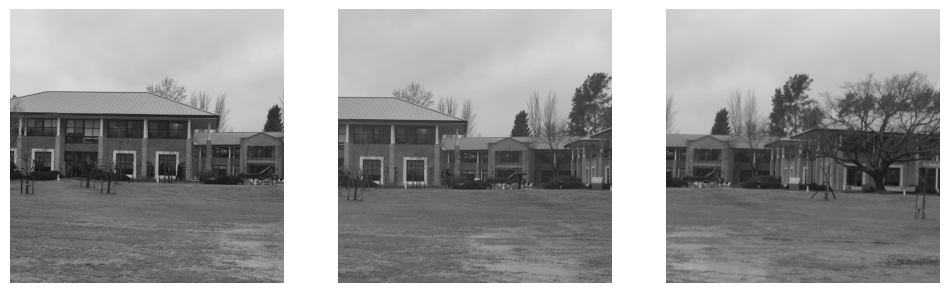

In [12]:
images = [cv2.cvtColor(plt.imread(f'img/udesa_{i}.jpg'), cv2.COLOR_RGB2GRAY) for i in range(0,3)]
show_images(images)

## Deteccion y Descripcion de Caracteristicas Visuales

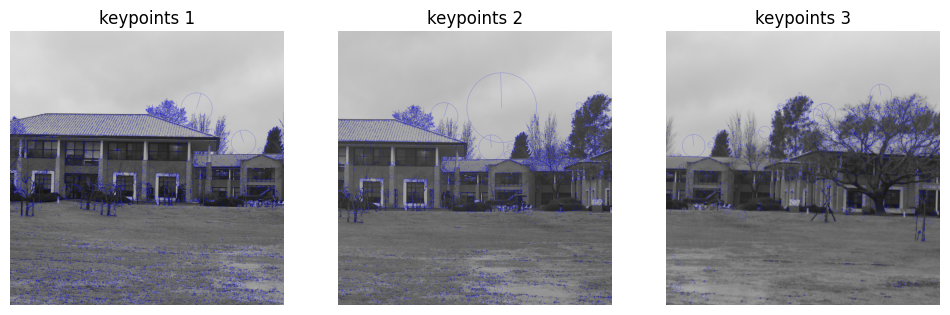

In [13]:
sift_algo = cv2.SIFT_create()
images_keypoints = []
images_descriptors = []

for i in range(len(images)):
    kp, des = sift_algo.detectAndCompute(images[i], None)
    images_keypoints.append(kp)
    images_descriptors.append(des)

images_with_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_kp = cv2.drawKeypoints(
        img_bgr,
        images_keypoints[i],
        0, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_kp.append(img_with_kp)

show_images(images_with_kp, ["keypoints 1", "keypoints 2", "keypoints 3"])



8864 6144 3025


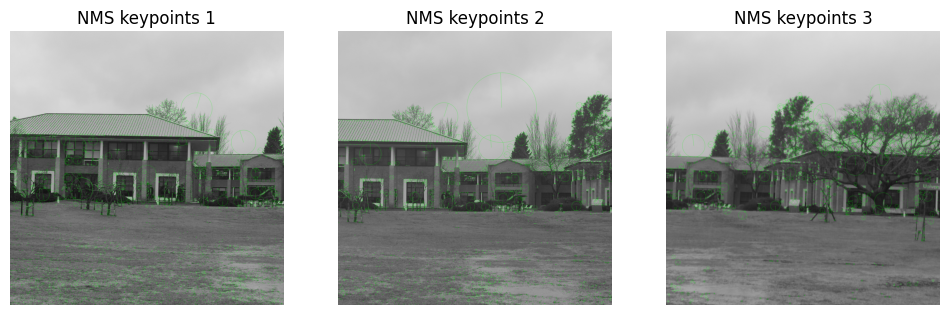

In [14]:
def apply_nms_to_keypoints_with_indices(keypoints, threshold=1000, N=10000):
    if not keypoints:
        return []

    keypoints = sorted(enumerate(keypoints), key=lambda x: x[1].response, reverse=True)
    filtered_indices = []
    filtered_keypoints = []

    for idx, kp in keypoints:
        keep = True
        for filtered_kp in filtered_keypoints:
            dist = np.sqrt((kp.pt[0] - filtered_kp.pt[0])**2 + (kp.pt[1] - filtered_kp.pt[1])**2)
            if dist < threshold:
                keep = False
                break
        if keep:
            filtered_keypoints.append(kp)
            filtered_indices.append(idx)

    return sorted(filtered_indices)[:N] 

nms_indices = []
for kp_list in images_keypoints:
    nms_indices.append(apply_nms_to_keypoints_with_indices(kp_list, threshold=10))

filtered_descriptors = []
for i, indices in enumerate(nms_indices):
    filtered_descriptors.append(images_descriptors[i][indices])

images_with_nms_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_nms_kp = cv2.drawKeypoints(
        img_bgr,
        [images_keypoints[i][idx] for idx in nms_indices[i]],
        0, (0, 255, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_nms_kp.append(img_with_nms_kp)

show_images(images_with_nms_kp, ["NMS keypoints 1", "NMS keypoints 2", "NMS keypoints 3"])
print(len(nms_indices[0]), len(nms_indices[1]), len(nms_indices[2]))

images_descriptors = filtered_descriptors

## Asociacion de Caracteristicas

### Cross-check

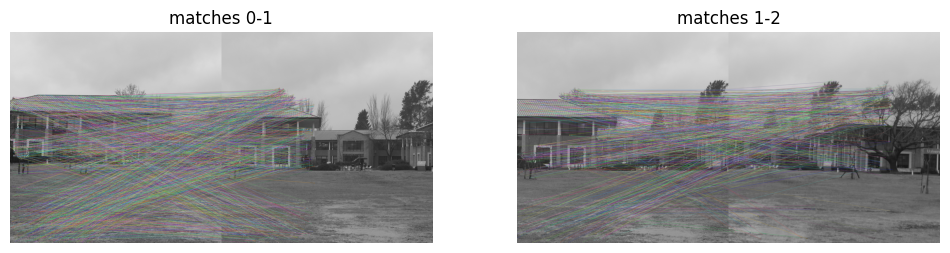

In [15]:
bf_cross = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match between image 0 and image 1
matches01 = bf_cross.match(images_descriptors[0], images_descriptors[1])
matches01 = sorted(matches01, key=lambda x: x.distance)

matched_img01_cross = cv2.drawMatches(
    images[0], images_keypoints[0], 
    images[1], images_keypoints[1], 
    matches01, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Match between image 1 and image 2
matches12 = bf_cross.match(images_descriptors[1], images_descriptors[2])
matches12 = sorted(matches12, key=lambda x: x.distance)

matched_img12_cross = cv2.drawMatches(
    images[1], images_keypoints[1], 
    images[2], images_keypoints[2], 
    matches12, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

show_images([matched_img01_cross, matched_img12_cross], ["matches 0-1", "matches 1-2"])


In [17]:
def compute_homography_dlt(p1, p2):
    p1 = np.asarray(p1, dtype=float)
    p2 = np.asarray(p2, dtype=float)
    N = p1.shape[0]
    A = []
    for i in range(N):
        x, y = p1[i, 0], p1[i, 1]
        xp, yp = p2[i, 0], p2[i, 1]
        row1 = [0, 0, 0, -x, -y, -1, yp*x, yp*y, yp]
        row2 = [x, y, 1, 0, 0, 0, -xp*x, -xp*y, -xp]
        A.append(row1)
        A.append(row2)
    A = np.asarray(A, dtype=float)
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape((3, 3))
    if H[2, 2] != 0:
        H = H / H[2, 2]
    return H

def apply_homography(H, points):
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed_points = points_homogeneous @ H.T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

def compute_precision(original_points, transformed_points):
    errors = np.linalg.norm(original_points - transformed_points, axis=1)
    return np.mean(errors)

p0 = [
    [2304, 1157],
    [2756, 1360],
    [2930, 1038],
    [2597, 1685],
]

p1 = [
    [1407, 1219],
    [1873, 1407],
    [2025, 1096],
    [1721, 1732],
    [2022, 1548]
]

p2 = [
    [466, 1381],
    [651, 1067],
    [311, 1714],
    [611, 1522]
]

p0_matched = np.array(p0)
p1_matched = np.array(p1[:-1])
H1 = compute_homography_dlt(p0_matched, p1_matched)

p1_matched_2 = np.array(p1[1:])
p2_matched = np.array(p2)
H2 = compute_homography_dlt(p1_matched_2, p2_matched)

p0_to_p1_transformed = apply_homography(H1, p0_matched)
p1_to_p2_transformed = apply_homography(H2, p1_matched_2)

precision_p0_p1 = compute_precision(p1_matched, p0_to_p1_transformed)
precision_p1_p2 = compute_precision(p2_matched, p1_to_p2_transformed)

precision_p0_p1, precision_p1_p2


(1.4924938099771976e-07, 1.5648489034941862e-08)

### Lowe´s Ratio

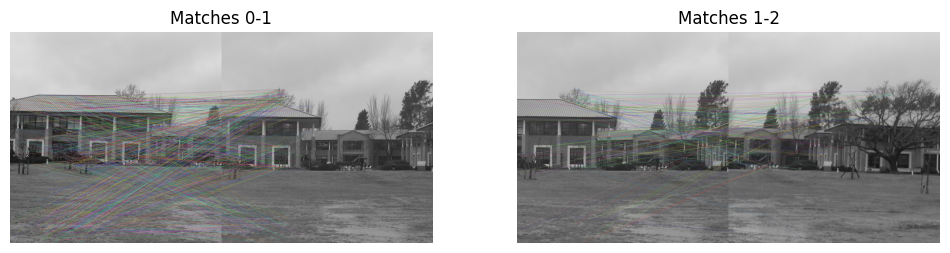

In [ ]:
bf_lowe = cv2.BFMatcher(cv2.NORM_L2)

matches01 = bf_lowe.knnMatch(images_descriptors[0], images_descriptors[1], k=2)
good_matches01 = []

for m, n in matches01:
    if m.distance < 0.75 * n.distance:
        good_matches01.append(m)

matched_img01_lowe = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    good_matches01, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)


matches12 = bf_lowe.knnMatch(images_descriptors[1], images_descriptors[2], k=2)
good_matches12 = []
for m, n in matches12:
    if m.distance < 0.75 * n.distance:
        good_matches12.append(m)

matched_img12_lowe = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    good_matches12, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

show_images([matched_img01_lowe, matched_img12_lowe], ["Matches 0-1", "Matches 1-2"])

### Cross-check vs Lowe´s Ratio

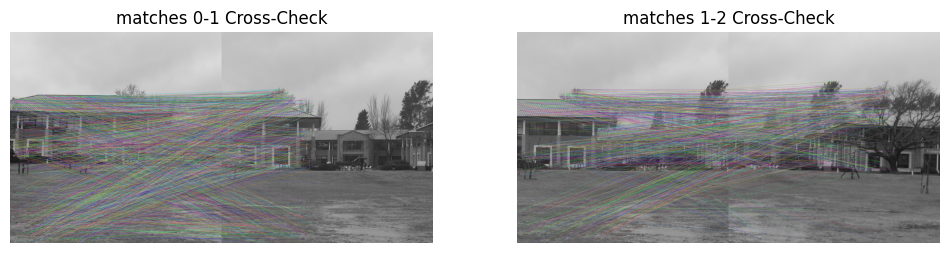

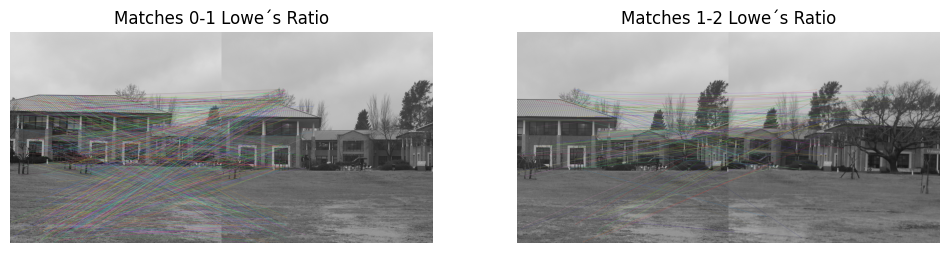

In [ ]:
show_images([matched_img01_cross, matched_img12_cross], ["matches 0-1 Cross-Check", "matches 1-2 Cross-Check"])
show_images([matched_img01_lowe, matched_img12_lowe], ["Matches 0-1 Lowe´s Ratio", "Matches 1-2 Lowe´s Ratio"])